In [25]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
#pip install xarray==v2023.06.0
import xarray as xr
from scipy import stats
from scipy import integrate
from numpy import exp
import math

from osgeo import gdal
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
## set the line width of the hatch
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.ticker as mticker

## mask forest and crop

In [2]:
## 789 anos normalized
ds_lai = xr.open_dataset('/portal1/dell/li-b/multiregression/lai.nc').sel(time=slice('2002-07-31', '2022-07-31'))
ds_ndvi = xr.open_dataset('/portal1/dell/li-b/multiregression/ndvi.nc').sel(time=slice('2002-07-01', '2022-07-01'))
ds_sif = xr.open_dataset('/portal1/dell/li-b/multiregression/sif.nc').sel(time=slice('2002-07-31', '2022-07-31'))

In [3]:
def varimask_forest(ds):
    mask = xr.open_dataset('/portal1/dell/li-b/multiregression/LC_IGBP_2022_epsg4326.tif')

    x = ds.dims['lon']
    y = ds.dims['lat']
    qc_a = mask['band_data'].sel(band=1).values
    qc_b = np.zeros((y, x), dtype=bool)
    qc_b = (qc_a==1) | (qc_a == 2) | (qc_a == 4) | (qc_a == 5)
    anos = np.zeros_like(ds['vari'].values)
    for t in range(0,ds_lai.dims['time']):    #### change the time length
        vari_a = ds['vari'][t,:,:].values
        vari_b = np.zeros((y, x))
        vari_b = np.where(qc_b, vari_a, np.nan)
        arr = vari_b.copy()##### exclude sichuan mountaions 
        arr[:80,:51] = np.nan
        anos[t,:,:] = arr
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
        
    return(ds_ex)

ds_lai1 = varimask_forest(ds_lai)
ds_ndvi1 = varimask_forest(ds_ndvi)
ds_sif1 = varimask_forest(ds_sif)

In [4]:
def varimask_crop(ds):
    mask = xr.open_dataset('/portal1/dell/li-b/multiregression/LC_IGBP_2022_epsg4326.tif')

    x = ds.dims['lon']
    y = ds.dims['lat']
    qc_a = mask['band_data'].sel(band=1).values
    qc_b = np.zeros((y, x), dtype=bool)
    qc_b = (qc_a == 12) | (qc_a == 14)
    anos = np.zeros_like(ds['vari'].values)
    for t in range(0,ds_lai.dims['time']):    
        vari_a = ds['vari'][t,:,:].values
        vari_b = np.zeros((y, x))
        vari_b = np.where(qc_b, vari_a, np.nan)
        anos[t,:,:] = vari_b
        
    ds_ex = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                                coords={ 'time': (['time'], ds.time.values),
                                        'lat': (['lat'], ds.lat.values),
                                        'lon': (['lon'], ds.lon.values)})
        
    return(ds_ex)

ds_lai2 = varimask_crop(ds_lai)
ds_ndvi2 = varimask_crop(ds_ndvi)
ds_sif2 = varimask_crop(ds_sif)

In [5]:
import pyhdf
from pyhdf.SD import SD, SDC  

f = SD('/portal1/dell/li-b/multiregression/MCD12C1.A2022001.061.2023244164746.hdf', SDC.READ)
# f.datasets()
newlat = np.linspace(89.975, -89.975, 3600) ## care about the order of lat and lon
newlon = np.linspace(-179.975, 179.975, 7200)

varis = f.select('Land_Cover_Type_1_Percent')[:,:,1]
ds_per1 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,2]
ds_per2 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,4]
ds_per4 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,5]
ds_per5 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,12]
ds_per12 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,14]
ds_per14 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

arrl1 = ds_per1['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl2 = ds_per2['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl4 = ds_per4['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl5 = ds_per5['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl12 = ds_per12['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl14 = ds_per14['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values

arr_p = arrl1 + arrl2 + arrl4 + arrl5
arr_p1 = arrl12 + arrl14

In [6]:
dem = xr.open_dataset('/portal1/dell/li-b/multiregression/dem0.05.nc')
dems = dem['vari'].sel(time='2022-12-31').values

## supple 1

In [7]:
from scipy.stats import pearsonr
coef0 = np.full((190, 231), np.nan)

for i in range(0,231):
    for j in range(0,190):
        dflai = ds_lai1['vari'][:,j,i].values
        dfndvi = ds_ndvi1['vari'][:,j,i].values
        df0 = pd.DataFrame({'lai':dflai, 'ndvi':dfndvi})
        df1 = df0.dropna()
        
        if len(df1) > 10:
            lai = df1['lai'].values.reshape(-1, 1).flatten()
            ndvi = df1['ndvi'].values.reshape(-1, 1) .flatten()
            corr_coeff = pearsonr(lai, ndvi)
            # if corr_coeff[1] < 0.1:
            coef0[j,i] = corr_coeff[0]
            
coe_fo = xr.Dataset({'vari': (['lat','lon'], coef0)},
                                coords={'lat': (['lat'], ds_lai1.lat.values),
                                        'lon': (['lon'], ds_lai1.lon.values)})

from scipy.stats import mode
def two_d_scatter(x_1d_data, x_1d ,y_1d_data, y_1d, z_1d_data, z_1d):
    bins = 100
    x = np.linspace(np.round(x_1d.min(), decimals=1), np.round(x_1d.max(), decimals=1), bins)
    y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(y_1d.max(), decimals=1), bins)
    # y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(800, decimals=1), bins) ### max=800 for crop
    x_gap = (x.max()-x.min())/bins
    y_gap = (y.max()-y.min())/bins
    out_2d_arr = xr.DataArray(np.zeros((bins,bins)), [('ydim',y),('xdim',x)])
    for i in range(bins):
        for j in range(bins):
            index = np.argwhere(
                (x_1d_data >= x[j]-x_gap/2) & (x_1d_data < x[j]+x_gap/2) & (y_1d_data >= y[i]-y_gap/2) & (y_1d_data < y[i]+y_gap/2)
            ).ravel()
            sel = z_1d_data[index]
            if len(sel) == 0:
                out_2d_arr[i][j] = np.nan
            else:
                results = mode(sel)
                out_2d_arr[i][j] = results.mode
    return(out_2d_arr)


x0 = arr_p.ravel()
x1 = arr_p[~np.isnan(arr_p)].ravel()
y0 = dems.ravel()
y1 = dems[~np.isnan(dems)].ravel()
zvari = coe_fo['vari'].values
z0 = zvari.ravel()
z1 = zvari[~np.isnan(zvari)].ravel()
scatter2d4 = two_d_scatter(x0,x1,y0,y1,z0,z1)

/tmp/ipykernel_218857/2057682525.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels(colorbar.ax.get_yticklabels())


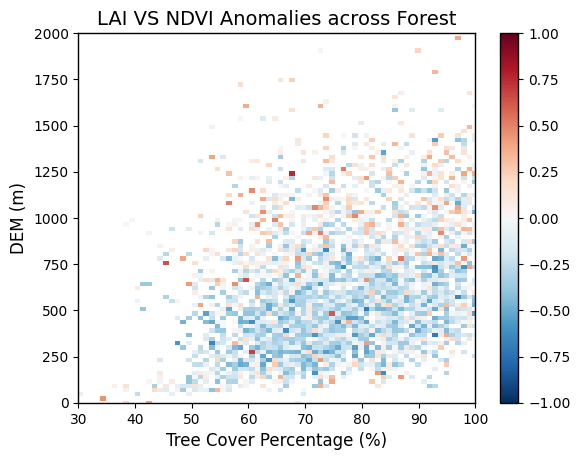

In [15]:
plot = scatter2d4.plot(vmax=1, vmin=-1, cmap='RdBu_r', cbar_kwargs={'extend':'neither'})
ax = plot.axes
ax.set_xlim(30, 100)
ax.set_ylim(0,2000)
ax.set_xlabel('Tree Cover Percentage (%)', fontsize=12)
ax.set_ylabel('DEM (m)', fontsize=12)
plt.title('LAI VS NDVI Anomalies across Forest',fontsize=14)


colorbar = plot.colorbar
colorbar.outline.set_linewidth(1)  # Adjust the value as needed
colorbar.set_ticklabels(colorbar.ax.get_yticklabels())
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=10)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(1)
plt.savefig('/portal1/dell/li-b/manu1_fig/fig4a.png', dpi=300, bbox_inches='tight') 
plt.show()

In [16]:
from scipy.stats import pearsonr
coef0 = np.full((190, 231), np.nan)

for i in range(0,231):
    for j in range(0,190):
        dflai = ds_lai2['vari'][:,j,i].values
        dfndvi = ds_ndvi2['vari'][:,j,i].values
        df0 = pd.DataFrame({'lai':dflai, 'ndvi':dfndvi})
        df1 = df0.dropna()
        
        if len(df1) > 10:
            lai = df1['lai'].values.reshape(-1, 1).flatten()
            ndvi = df1['ndvi'].values.reshape(-1, 1).flatten()
            corr_coeff = pearsonr(lai, ndvi)
            # if corr_coeff[1] < 0.1:
            coef0[j,i] = corr_coeff[0]
            
coe_fo = xr.Dataset({'vari': (['lat','lon'], coef0)},
                                coords={'lat': (['lat'], ds_lai1.lat.values),
                                        'lon': (['lon'], ds_lai1.lon.values)})

from scipy.stats import mode
def two_d_scatter(x_1d_data, x_1d ,y_1d_data, y_1d, z_1d_data, z_1d):
    bins = 100
    x = np.linspace(np.round(x_1d.min(), decimals=1), np.round(x_1d.max(), decimals=1), bins)
    # y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(y_1d.max(), decimals=1), bins)
    y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(800, decimals=1), bins) ### max=800 for crop
    x_gap = (x.max()-x.min())/bins
    y_gap = (y.max()-y.min())/bins
    out_2d_arr = xr.DataArray(np.zeros((bins,bins)), [('ydim',y),('xdim',x)])
    for i in range(bins):
        for j in range(bins):
            index = np.argwhere(
                (x_1d_data >= x[j]-x_gap/2) & (x_1d_data < x[j]+x_gap/2) & (y_1d_data >= y[i]-y_gap/2) & (y_1d_data < y[i]+y_gap/2)
            ).ravel()
            sel = z_1d_data[index]
            if len(sel) == 0:
                out_2d_arr[i][j] = np.nan
            else:
                results = mode(sel)
                out_2d_arr[i][j] = results.mode
    return(out_2d_arr)


x0 = arr_p1.ravel()
x1 = arr_p1[~np.isnan(arr_p1)].ravel()
y0 = dems.ravel()
y1 = dems[~np.isnan(dems)].ravel()
zvari = coe_fo['vari'].values
z0 = zvari.ravel()
z1 = zvari[~np.isnan(zvari)].ravel()
scatter2d5 = two_d_scatter(x0,x1,y0,y1,z0,z1)

/tmp/ipykernel_218857/3852394459.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels(colorbar.ax.get_yticklabels())


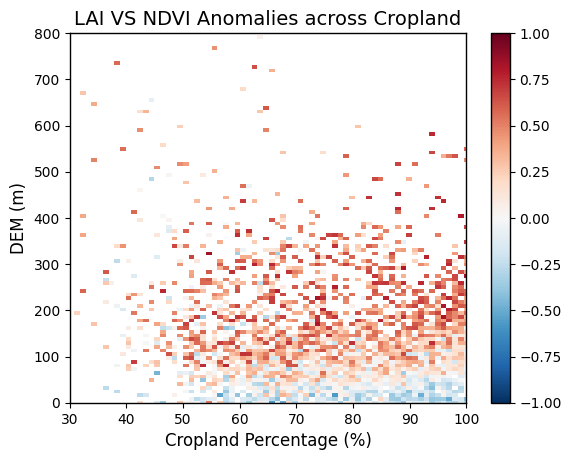

In [20]:
plot = scatter2d5.plot(vmax=1, vmin=-1, cmap='RdBu_r', cbar_kwargs={'extend':'neither'})
ax = plot.axes
ax.set_xlim(30, 100)
ax.set_ylim(0,800)
ax.set_xlabel('Cropland Percentage (%)', fontsize=12)
ax.set_ylabel('DEM (m)', fontsize=12)
plt.title('LAI VS NDVI Anomalies across Cropland',fontsize=14)


colorbar = plot.colorbar
colorbar.outline.set_linewidth(1)  # Adjust the value as needed
colorbar.set_ticklabels(colorbar.ax.get_yticklabels())
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=10)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(1)
plt.savefig('/portal1/dell/li-b/manu1_fig/fig4d.png', dpi=300, bbox_inches='tight') 

plt.show()

In [17]:
from scipy.stats import pearsonr
coef0 = np.full((190, 231), np.nan)

for i in range(0,231):
    for j in range(0,190):
        dflai = ds_lai1['vari'][:,j,i].values
        dfndvi = ds_sif1['vari'][:,j,i].values
        df0 = pd.DataFrame({'lai':dflai, 'ndvi':dfndvi})
        df1 = df0.dropna()
        
        if len(df1) > 10:
            lai = df1['lai'].values.reshape(-1, 1).flatten()
            ndvi = df1['ndvi'].values.reshape(-1, 1).flatten()
            corr_coeff = pearsonr(lai, ndvi)
            # if corr_coeff[1] < 0.1:
            coef0[j,i] = corr_coeff[0]
            
coe_fo = xr.Dataset({'vari': (['lat','lon'], coef0)},
                                coords={'lat': (['lat'], ds_lai1.lat.values),
                                        'lon': (['lon'], ds_lai1.lon.values)})

from scipy.stats import mode
def two_d_scatter(x_1d_data, x_1d ,y_1d_data, y_1d, z_1d_data, z_1d):
    bins = 100
    x = np.linspace(np.round(x_1d.min(), decimals=1), np.round(x_1d.max(), decimals=1), bins)
    y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(y_1d.max(), decimals=1), bins)
    # y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(800, decimals=1), bins) ### max=800 for crop
    x_gap = (x.max()-x.min())/bins
    y_gap = (y.max()-y.min())/bins
    out_2d_arr = xr.DataArray(np.zeros((bins,bins)), [('ydim',y),('xdim',x)])
    for i in range(bins):
        for j in range(bins):
            index = np.argwhere(
                (x_1d_data >= x[j]-x_gap/2) & (x_1d_data < x[j]+x_gap/2) & (y_1d_data >= y[i]-y_gap/2) & (y_1d_data < y[i]+y_gap/2)
            ).ravel()
            sel = z_1d_data[index]
            if len(sel) == 0:
                out_2d_arr[i][j] = np.nan
            else:
                results = mode(sel)
                out_2d_arr[i][j] = results.mode
    return(out_2d_arr)


x0 = arr_p.ravel()
x1 = arr_p[~np.isnan(arr_p)].ravel()
y0 = dems.ravel()
y1 = dems[~np.isnan(dems)].ravel()
zvari = coe_fo['vari'].values
z0 = zvari.ravel()
z1 = zvari[~np.isnan(zvari)].ravel()
scatter2d8 = two_d_scatter(x0,x1,y0,y1,z0,z1)

/tmp/ipykernel_218857/2658011145.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels(colorbar.ax.get_yticklabels())


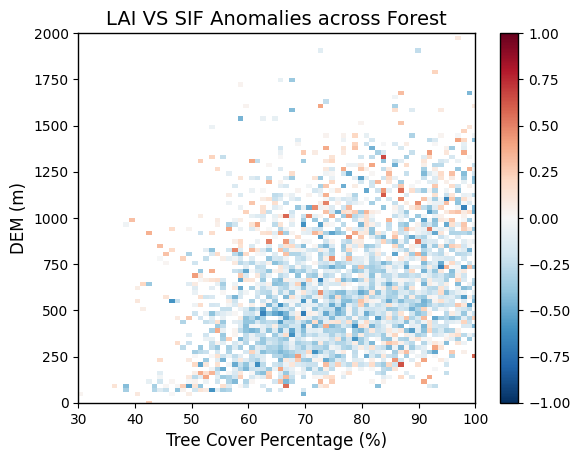

In [21]:
plot = scatter2d8.plot(vmax=1, vmin=-1, cmap='RdBu_r', cbar_kwargs={'extend':'neither'})
ax = plot.axes
ax.set_xlim(30, 100)
ax.set_ylim(0,2000)
ax.set_xlabel('Tree Cover Percentage (%)', fontsize=12)
ax.set_ylabel('DEM (m)', fontsize=12)
plt.title('LAI VS SIF Anomalies across Forest',fontsize=14)


colorbar = plot.colorbar
colorbar.outline.set_linewidth(1)  # Adjust the value as needed
colorbar.set_ticklabels(colorbar.ax.get_yticklabels())
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=10)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(1)
plt.savefig('/portal1/dell/li-b/manu1_fig/fig4b.png', dpi=300, bbox_inches='tight') 

plt.show()

/tmp/ipykernel_218857/2249758207.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels(colorbar.ax.get_yticklabels())


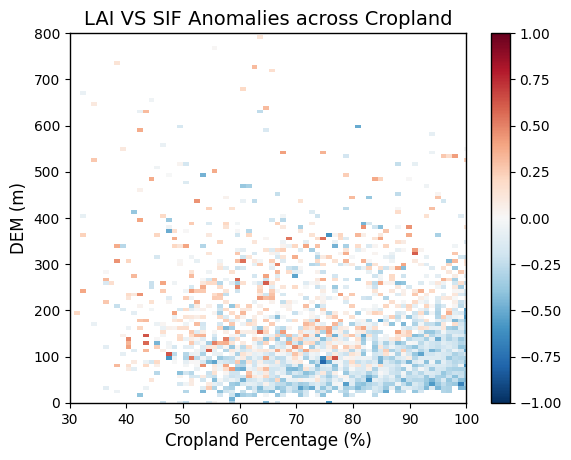

In [22]:
from scipy.stats import pearsonr
coef0 = np.full((190, 231), np.nan)

for i in range(0,231):
    for j in range(0,190):
        dflai = ds_lai2['vari'][:,j,i].values
        dfndvi = ds_sif2['vari'][:,j,i].values
        df0 = pd.DataFrame({'lai':dflai, 'ndvi':dfndvi})
        df1 = df0.dropna()
        
        if len(df1) > 10:
            lai = df1['lai'].values.reshape(-1, 1).flatten()
            ndvi = df1['ndvi'].values.reshape(-1, 1).flatten()
            corr_coeff = pearsonr(lai, ndvi)
            # if corr_coeff[1] < 0.1:
            coef0[j,i] = corr_coeff[0]
            
coe_fo = xr.Dataset({'vari': (['lat','lon'], coef0)},
                                coords={'lat': (['lat'], ds_lai1.lat.values),
                                        'lon': (['lon'], ds_lai1.lon.values)})

from scipy.stats import mode
def two_d_scatter(x_1d_data, x_1d ,y_1d_data, y_1d, z_1d_data, z_1d):
    bins = 100
    x = np.linspace(np.round(x_1d.min(), decimals=1), np.round(x_1d.max(), decimals=1), bins)
    # y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(y_1d.max(), decimals=1), bins)
    y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(800, decimals=1), bins) ### max=800 for crop
    x_gap = (x.max()-x.min())/bins
    y_gap = (y.max()-y.min())/bins
    out_2d_arr = xr.DataArray(np.zeros((bins,bins)), [('ydim',y),('xdim',x)])
    for i in range(bins):
        for j in range(bins):
            index = np.argwhere(
                (x_1d_data >= x[j]-x_gap/2) & (x_1d_data < x[j]+x_gap/2) & (y_1d_data >= y[i]-y_gap/2) & (y_1d_data < y[i]+y_gap/2)
            ).ravel()
            sel = z_1d_data[index]
            if len(sel) == 0:
                out_2d_arr[i][j] = np.nan
            else:
                results = mode(sel)
                out_2d_arr[i][j] = results.mode
    return(out_2d_arr)


x0 = arr_p1.ravel()
x1 = arr_p1[~np.isnan(arr_p1)].ravel()
y0 = dems.ravel()
y1 = dems[~np.isnan(dems)].ravel()
zvari = coe_fo['vari'].values
z0 = zvari.ravel()
z1 = zvari[~np.isnan(zvari)].ravel()
scatter2d9 = two_d_scatter(x0,x1,y0,y1,z0,z1)

plot = scatter2d9.plot(vmax=1, vmin=-1, cmap='RdBu_r', cbar_kwargs={'extend':'neither'})
ax = plot.axes
ax.set_xlim(30, 100)
ax.set_ylim(0,800)
ax.set_xlabel('Cropland Percentage (%)', fontsize=12)
ax.set_ylabel('DEM (m)', fontsize=12)
plt.title('LAI VS SIF Anomalies across Cropland',fontsize=14)


colorbar = plot.colorbar
colorbar.outline.set_linewidth(1)  # Adjust the value as needed
colorbar.set_ticklabels(colorbar.ax.get_yticklabels())
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=10)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(1)
plt.savefig('/portal1/dell/li-b/manu1_fig/fig4e.png', dpi=300, bbox_inches='tight') 

plt.show()

/tmp/ipykernel_218857/1223351365.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels(colorbar.ax.get_yticklabels())


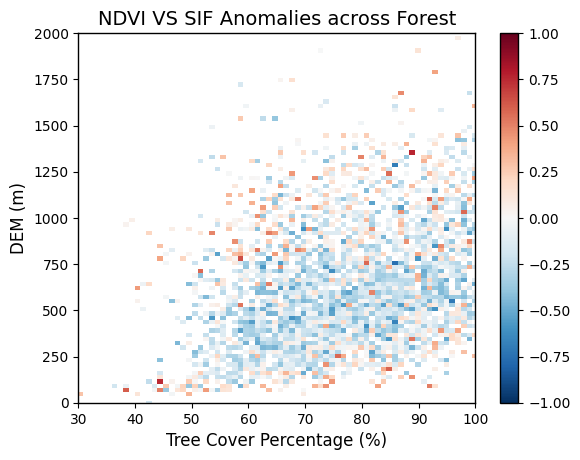

In [28]:
from scipy.stats import pearsonr
coef0 = np.full((190, 231), np.nan)

for i in range(0,231):
    for j in range(0,190):
        dflai = ds_sif1['vari'][:,j,i].values
        dfndvi = ds_ndvi1['vari'][:,j,i].values
        df0 = pd.DataFrame({'lai':dflai, 'ndvi':dfndvi})
        df1 = df0.dropna()
        
        if len(df1) > 10:
            lai = df1['lai'].values.reshape(-1, 1).flatten()
            ndvi = df1['ndvi'].values.reshape(-1, 1).flatten()
            corr_coeff = pearsonr(lai, ndvi)
            # if corr_coeff[1] < 0.1:
            coef0[j,i] = corr_coeff[0]
            
coe_fo = xr.Dataset({'vari': (['lat','lon'], coef0)},
                                coords={'lat': (['lat'], ds_lai1.lat.values),
                                        'lon': (['lon'], ds_lai1.lon.values)})

from scipy.stats import mode
def two_d_scatter(x_1d_data, x_1d ,y_1d_data, y_1d, z_1d_data, z_1d):
    bins = 100
    x = np.linspace(np.round(x_1d.min(), decimals=1), np.round(x_1d.max(), decimals=1), bins)
    y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(y_1d.max(), decimals=1), bins)
    # y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(800, decimals=1), bins) ### max=800 for crop
    x_gap = (x.max()-x.min())/bins
    y_gap = (y.max()-y.min())/bins
    out_2d_arr = xr.DataArray(np.zeros((bins,bins)), [('ydim',y),('xdim',x)])
    for i in range(bins):
        for j in range(bins):
            index = np.argwhere(
                (x_1d_data >= x[j]-x_gap/2) & (x_1d_data < x[j]+x_gap/2) & (y_1d_data >= y[i]-y_gap/2) & (y_1d_data < y[i]+y_gap/2)
            ).ravel()
            sel = z_1d_data[index]
            if len(sel) == 0:
                out_2d_arr[i][j] = np.nan
            else:
                results = mode(sel)
                out_2d_arr[i][j] = results.mode
    return(out_2d_arr)


x0 = arr_p.ravel()
x1 = arr_p[~np.isnan(arr_p)].ravel()
y0 = dems.ravel()
y1 = dems[~np.isnan(dems)].ravel()
zvari = coe_fo['vari'].values
z0 = zvari.ravel()
z1 = zvari[~np.isnan(zvari)].ravel()
scatter2d10 = two_d_scatter(x0,x1,y0,y1,z0,z1)

plot = scatter2d10.plot(vmax=1, vmin=-1, cmap='RdBu_r', cbar_kwargs={'extend':'neither'})
ax = plot.axes
ax.set_xlim(30, 100)
ax.set_ylim(0,2000)
ax.set_xlabel('Tree Cover Percentage (%)', fontsize=12)
ax.set_ylabel('DEM (m)', fontsize=12)
plt.title('NDVI VS SIF Anomalies across Forest',fontsize=14)


colorbar = plot.colorbar
colorbar.outline.set_linewidth(1)  # Adjust the value as needed
colorbar.set_ticklabels(colorbar.ax.get_yticklabels())
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=10)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(1)
plt.savefig('/portal1/dell/li-b/manu1_fig/fig4c.png', dpi=300, bbox_inches='tight') 

plt.show()

In [29]:
from scipy.stats import pearsonr
coef0 = np.full((190, 231), np.nan)

for i in range(0,231):
    for j in range(0,190):
        dflai = ds_sif2['vari'][:,j,i].values
        dfndvi = ds_ndvi2['vari'][:,j,i].values
        df0 = pd.DataFrame({'lai':dflai, 'ndvi':dfndvi})
        df1 = df0.dropna()
        
        if len(df1) > 10:
            lai = df1['lai'].values.reshape(-1, 1).flatten()
            ndvi = df1['ndvi'].values.reshape(-1, 1).flatten()
            corr_coeff = pearsonr(lai, ndvi)
            # if corr_coeff[1] < 0.1:
            coef0[j,i] = corr_coeff[0]
            
coe_fo = xr.Dataset({'vari': (['lat','lon'], coef0)},
                                coords={'lat': (['lat'], ds_lai1.lat.values),
                                        'lon': (['lon'], ds_lai1.lon.values)})

from scipy.stats import mode
def two_d_scatter(x_1d_data, x_1d ,y_1d_data, y_1d, z_1d_data, z_1d):
    bins = 100
    x = np.linspace(np.round(x_1d.min(), decimals=1), np.round(x_1d.max(), decimals=1), bins)
    # y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(y_1d.max(), decimals=1), bins)
    y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(800, decimals=1), bins) ### max=800 for crop
    x_gap = (x.max()-x.min())/bins
    y_gap = (y.max()-y.min())/bins
    out_2d_arr = xr.DataArray(np.zeros((bins,bins)), [('ydim',y),('xdim',x)])
    for i in range(bins):
        for j in range(bins):
            index = np.argwhere(
                (x_1d_data >= x[j]-x_gap/2) & (x_1d_data < x[j]+x_gap/2) & (y_1d_data >= y[i]-y_gap/2) & (y_1d_data < y[i]+y_gap/2)
            ).ravel()
            sel = z_1d_data[index]
            if len(sel) == 0:
                out_2d_arr[i][j] = np.nan
            else:
                results = mode(sel)
                out_2d_arr[i][j] = results.mode
    return(out_2d_arr)


x0 = arr_p1.ravel()
x1 = arr_p1[~np.isnan(arr_p1)].ravel()
y0 = dems.ravel()
y1 = dems[~np.isnan(dems)].ravel()
zvari = coe_fo['vari'].values
z0 = zvari.ravel()
z1 = zvari[~np.isnan(zvari)].ravel()
scatter2d11 = two_d_scatter(x0,x1,y0,y1,z0,z1)

/tmp/ipykernel_218857/345067021.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels(colorbar.ax.get_yticklabels())


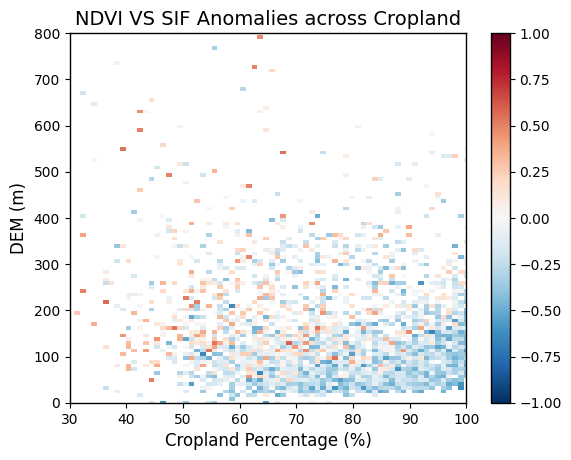

In [30]:
plot = scatter2d11.plot(vmax=1, vmin=-1, cmap='RdBu_r', cbar_kwargs={'extend':'neither'})
ax = plot.axes
ax.set_xlim(30, 100)
ax.set_ylim(0,800)
ax.set_xlabel('Cropland Percentage (%)', fontsize=12)
ax.set_ylabel('DEM (m)', fontsize=12)
plt.title('NDVI VS SIF Anomalies across Cropland',fontsize=14)


colorbar = plot.colorbar
colorbar.outline.set_linewidth(1)  # Adjust the value as needed
colorbar.set_ticklabels(colorbar.ax.get_yticklabels())
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=10)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(1)
plt.savefig('/portal1/dell/li-b/manu1_fig/fig4f.png', dpi=300, bbox_inches='tight') 

plt.show()

## fig 3

In [31]:
from scipy.stats import mode
def two_d_scatter(x_1d_data, x_1d ,y_1d_data, y_1d, z_1d_data, z_1d):
    bins = 100
    x = np.linspace(np.round(x_1d.min(), decimals=1), np.round(x_1d.max(), decimals=1), bins)
    y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(y_1d.max(), decimals=1), bins)
    # y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(800, decimals=1), bins) ### max=800 for crop
    x_gap = (x.max()-x.min())/bins
    y_gap = (y.max()-y.min())/bins
    out_2d_arr = xr.DataArray(np.zeros((bins,bins)), [('ydim',y),('xdim',x)])
    for i in range(bins):
        for j in range(bins):
            index = np.argwhere(
                (x_1d_data >= x[j]-x_gap/2) & (x_1d_data < x[j]+x_gap/2) & (y_1d_data >= y[i]-y_gap/2) & (y_1d_data < y[i]+y_gap/2)
            ).ravel()
            sel = z_1d_data[index]
            if len(sel) == 0:
                out_2d_arr[i][j] = np.nan
            else:
                results = mode(sel)
                out_2d_arr[i][j] = results.mode
    return(out_2d_arr)

x0 = arr_p.ravel()
x1 = arr_p[~np.isnan(arr_p)].ravel()
y0 = dems.ravel()
y1 = dems[~np.isnan(dems)].ravel()
zvari = ds_lai1['vari'][20,:,:].values.reshape(-1, 1).flatten()
z0 = zvari.ravel()
z1 = zvari[~np.isnan(zvari)].ravel()
scatter2d0 = two_d_scatter(x0,x1,y0,y1,z0,z1)

x0 = arr_p.ravel()
x1 = arr_p[~np.isnan(arr_p)].ravel()
y0 = dems.ravel()
y1 = dems[~np.isnan(dems)].ravel()
zvari = ds_ndvi1['vari'][20,:,:].values.reshape(-1, 1).flatten()
z0 = zvari.ravel()
z1 = zvari[~np.isnan(zvari)].ravel()
scatter2d1 = two_d_scatter(x0,x1,y0,y1,z0,z1)

x0 = arr_p.ravel()
x1 = arr_p[~np.isnan(arr_p)].ravel()
y0 = dems.ravel()
y1 = dems[~np.isnan(dems)].ravel()
zvari = ds_sif1['vari'][20,:,:].values.reshape(-1, 1).flatten()
z0 = zvari.ravel()
z1 = zvari[~np.isnan(zvari)].ravel()
scatter2d6 = two_d_scatter(x0,x1,y0,y1,z0,z1)

In [32]:
from scipy.stats import mode
def two_d_scatter(x_1d_data, x_1d ,y_1d_data, y_1d, z_1d_data, z_1d):
    bins = 100
    x = np.linspace(np.round(x_1d.min(), decimals=1), np.round(x_1d.max(), decimals=1), bins)
    # y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(y_1d.max(), decimals=1), bins)
    y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(800, decimals=1), bins) ### max=800 for crop
    x_gap = (x.max()-x.min())/bins
    y_gap = (y.max()-y.min())/bins
    out_2d_arr = xr.DataArray(np.zeros((bins,bins)), [('ydim',y),('xdim',x)])
    for i in range(bins):
        for j in range(bins):
            index = np.argwhere(
                (x_1d_data >= x[j]-x_gap/2) & (x_1d_data < x[j]+x_gap/2) & (y_1d_data >= y[i]-y_gap/2) & (y_1d_data < y[i]+y_gap/2)
            ).ravel()
            sel = z_1d_data[index]
            if len(sel) == 0:
                out_2d_arr[i][j] = np.nan
            else:
                results = mode(sel)
                out_2d_arr[i][j] = results.mode
    return(out_2d_arr)

## change the def max=800 for crop
x0 = arr_p1.ravel()
x1 = arr_p1[~np.isnan(arr_p1)].ravel()
y0 = dems.ravel()
y1 = dems[~np.isnan(dems)].ravel()
zvari = ds_lai2['vari'][20,:,:].values.reshape(-1, 1).flatten()
z0 = zvari.ravel()
z1 = zvari[~np.isnan(zvari)].ravel()
scatter2d2 = two_d_scatter(x0,x1,y0,y1,z0,z1)

x0 = arr_p1.ravel()
x1 = arr_p1[~np.isnan(arr_p1)].ravel()
y0 = dems.ravel()
y1 = dems[~np.isnan(dems)].ravel()
zvari = ds_ndvi2['vari'][20,:,:].values.reshape(-1, 1).flatten()
z0 = zvari.ravel()
z1 = zvari[~np.isnan(zvari)].ravel()
scatter2d3 = two_d_scatter(x0,x1,y0,y1,z0,z1)

x0 = arr_p1.ravel()
x1 = arr_p1[~np.isnan(arr_p1)].ravel()
y0 = dems.ravel()
y1 = dems[~np.isnan(dems)].ravel()
zvari = ds_sif2['vari'][20,:,:].values.reshape(-1, 1).flatten()
z0 = zvari.ravel()
z1 = zvari[~np.isnan(zvari)].ravel()
scatter2d7 = two_d_scatter(x0,x1,y0,y1,z0,z1)

/tmp/ipykernel_218857/1083135627.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels(colorbar.ax.get_yticklabels())


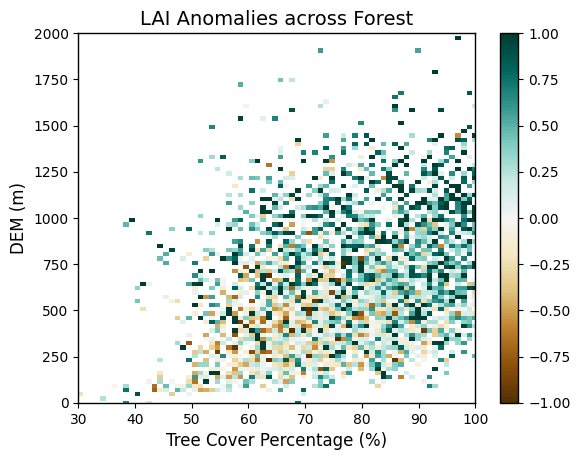

In [33]:
plot = scatter2d0.plot(vmax=1, vmin=-1, cmap='BrBG', cbar_kwargs={'extend':'neither'})
ax = plot.axes
ax.set_xlim(30, 100)
ax.set_ylim(0,2000)
ax.set_xlabel('Tree Cover Percentage (%)', fontsize=12)
ax.set_ylabel('DEM (m)', fontsize=12)
plt.title('LAI Anomalies across Forest',fontsize=14)


colorbar = plot.colorbar
colorbar.outline.set_linewidth(1)  # Adjust the value as needed
colorbar.set_ticklabels(colorbar.ax.get_yticklabels())
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=10)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(1)
plt.savefig('/portal1/dell/li-b/manu1_fig/fig3a.png', dpi=300, bbox_inches='tight') 

plt.show()

/tmp/ipykernel_218857/1416655930.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels(colorbar.ax.get_yticklabels())


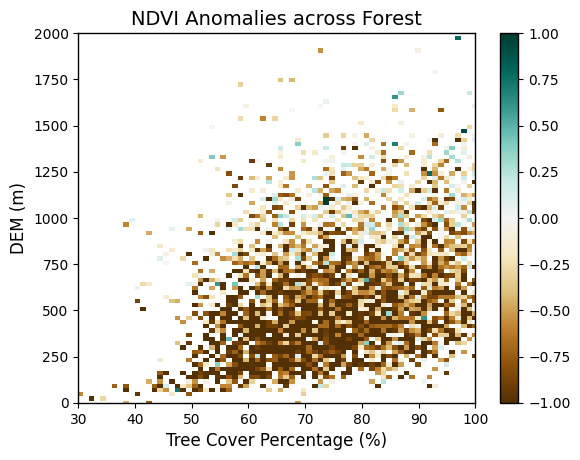

In [34]:
plot = scatter2d1.plot(vmax=1, vmin=-1, cmap='BrBG', cbar_kwargs={'extend':'neither'})
ax = plot.axes
ax.set_xlim(30, 100)
ax.set_ylim(0,2000)
ax.set_xlabel('Tree Cover Percentage (%)', fontsize=12)
ax.set_ylabel('DEM (m)', fontsize=12)
plt.title('NDVI Anomalies across Forest',fontsize=14)


colorbar = plot.colorbar
colorbar.outline.set_linewidth(1)  # Adjust the value as needed
colorbar.set_ticklabels(colorbar.ax.get_yticklabels())
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=10)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(1)
plt.savefig('/portal1/dell/li-b/manu1_fig/fig3c.png', dpi=300, bbox_inches='tight') 

plt.show()

/tmp/ipykernel_218857/1315133253.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels(colorbar.ax.get_yticklabels())


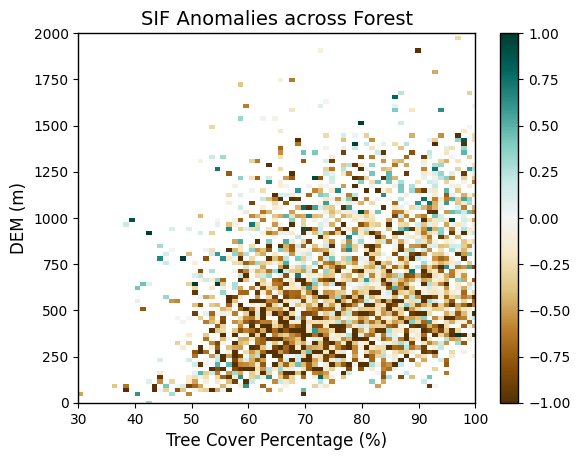

In [35]:
plot = scatter2d6.plot(vmax=1, vmin=-1, cmap='BrBG', cbar_kwargs={'extend':'neither'})
ax = plot.axes
ax.set_xlim(30, 100)
ax.set_ylim(0,2000)
ax.set_xlabel('Tree Cover Percentage (%)', fontsize=12)
ax.set_ylabel('DEM (m)', fontsize=12)
plt.title('SIF Anomalies across Forest',fontsize=14)


colorbar = plot.colorbar
colorbar.outline.set_linewidth(1)  # Adjust the value as needed
colorbar.set_ticklabels(colorbar.ax.get_yticklabels())
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=10)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(1)
plt.savefig('/portal1/dell/li-b/manu1_fig/fig3b.png', dpi=300, bbox_inches='tight') 

plt.show()

/tmp/ipykernel_218857/984766931.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels(colorbar.ax.get_yticklabels())


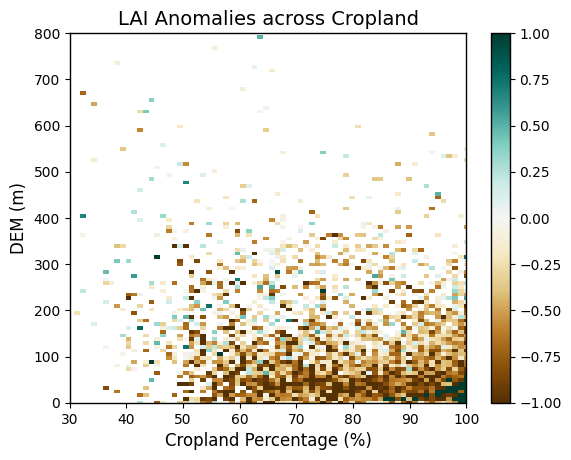

In [39]:
plot = scatter2d2.plot(vmax=1, vmin=-1, cmap='BrBG', cbar_kwargs={'extend':'neither'})
ax = plot.axes
ax.set_xlim(30, 100)
ax.set_ylim(0,800)
ax.set_xlabel('Cropland Percentage (%)', fontsize=12)
ax.set_ylabel('DEM (m)', fontsize=12)
plt.title('LAI Anomalies across Cropland',fontsize=14)


colorbar = plot.colorbar
colorbar.outline.set_linewidth(1)  # Adjust the value as needed
colorbar.set_ticklabels(colorbar.ax.get_yticklabels())
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=10)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(1)
plt.savefig('/portal1/dell/li-b/manu1_fig/fig3d.png', dpi=300, bbox_inches='tight') 

plt.show()

/tmp/ipykernel_218857/3063757550.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels(colorbar.ax.get_yticklabels())


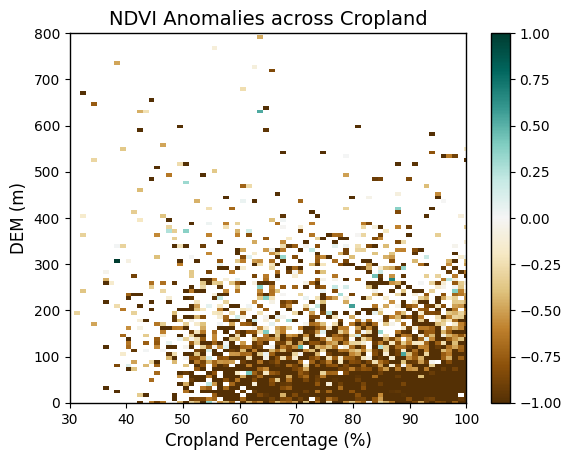

In [40]:
plot = scatter2d3.plot(vmax=1, vmin=-1, cmap='BrBG', cbar_kwargs={'extend':'neither'})
ax = plot.axes
ax.set_xlim(30, 100)
ax.set_ylim(0,800)
ax.set_xlabel('Cropland Percentage (%)', fontsize=12)
ax.set_ylabel('DEM (m)', fontsize=12)
plt.title('NDVI Anomalies across Cropland',fontsize=14)


colorbar = plot.colorbar
colorbar.outline.set_linewidth(1)  # Adjust the value as needed
colorbar.set_ticklabels(colorbar.ax.get_yticklabels())
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=10)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(1)
plt.savefig('/portal1/dell/li-b/manu1_fig/fig3f.png', dpi=300, bbox_inches='tight') 

plt.show()

/tmp/ipykernel_218857/227849822.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  colorbar.set_ticklabels(colorbar.ax.get_yticklabels())


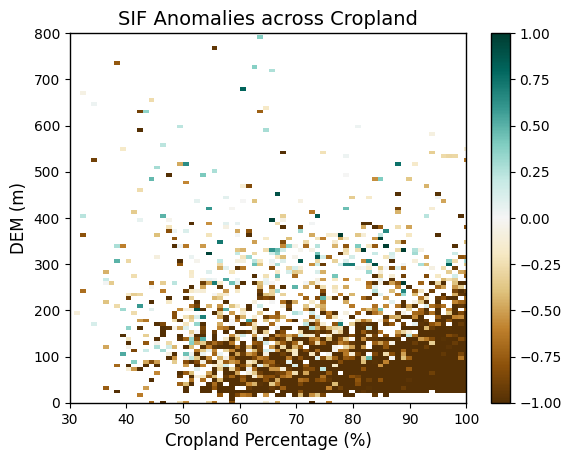

In [41]:
plot = scatter2d7.plot(vmax=1, vmin=-1, cmap='BrBG', cbar_kwargs={'extend':'neither'})
ax = plot.axes
ax.set_xlim(30, 100)
ax.set_ylim(0,800)
ax.set_xlabel('Cropland Percentage (%)', fontsize=12)
ax.set_ylabel('DEM (m)', fontsize=12)
plt.title('SIF Anomalies across Cropland',fontsize=14)


colorbar = plot.colorbar
colorbar.outline.set_linewidth(1)  # Adjust the value as needed
colorbar.set_ticklabels(colorbar.ax.get_yticklabels())
ax.set_xticks(ax.get_xticks())
ax.set_yticks(ax.get_yticks())
ax.set_xticklabels([int(x) for x in ax.get_xticks()], fontsize=10)
ax.set_yticklabels([int(y) for y in ax.get_yticks()], fontsize=10)
for spine in ax.spines.values():
    spine.set_linewidth(1)
plt.savefig('/portal1/dell/li-b/manu1_fig/fig3e.png', dpi=300, bbox_inches='tight') 

plt.show()

In [10]:
z0 = ds_lai1['vari'][20,:,:].values.ravel()
z1 = ds_ndvi1['vari'][20,:,:].values.ravel()
z2 = ds_lai2['vari'][20,:,:].values.ravel()
z3 = ds_ndvi2['vari'][20,:,:].values.ravel()

In [17]:
mu = ds_lai1['vari'][20,:,:].mean(dim=['lat','lon'], skipna=True).values
std = ds_lai1['vari'][20,:,:].std(dim=['lat','lon'], skipna=True).values
print(mu, std)
mu = ds_ndvi1['vari'][20,:,:].mean(dim=['lat','lon'], skipna=True).values
std = ds_ndvi1['vari'][20,:,:].std(dim=['lat','lon'], skipna=True).values
print(mu, std)
mu = ds_lai2['vari'][20,:,:].mean(dim=['lat','lon'], skipna=True).values
std = ds_lai2['vari'][20,:,:].std(dim=['lat','lon'], skipna=True).values
print(mu, std)
mu = ds_ndvi2['vari'][20,:,:].mean(dim=['lat','lon'], skipna=True).values
std = ds_ndvi2['vari'][20,:,:].std(dim=['lat','lon'], skipna=True).values
print(mu, std)

0.32055401680874496 0.3046041699135574
-0.01832470053268445 0.020782506040697372
0.023710911785046012 0.20219238430391112
-0.01871435237240901 0.0421286729140436


Text(0.5, 1.0, 'Relationship of Normalized LAI and NDVI Anomalies across Forest')

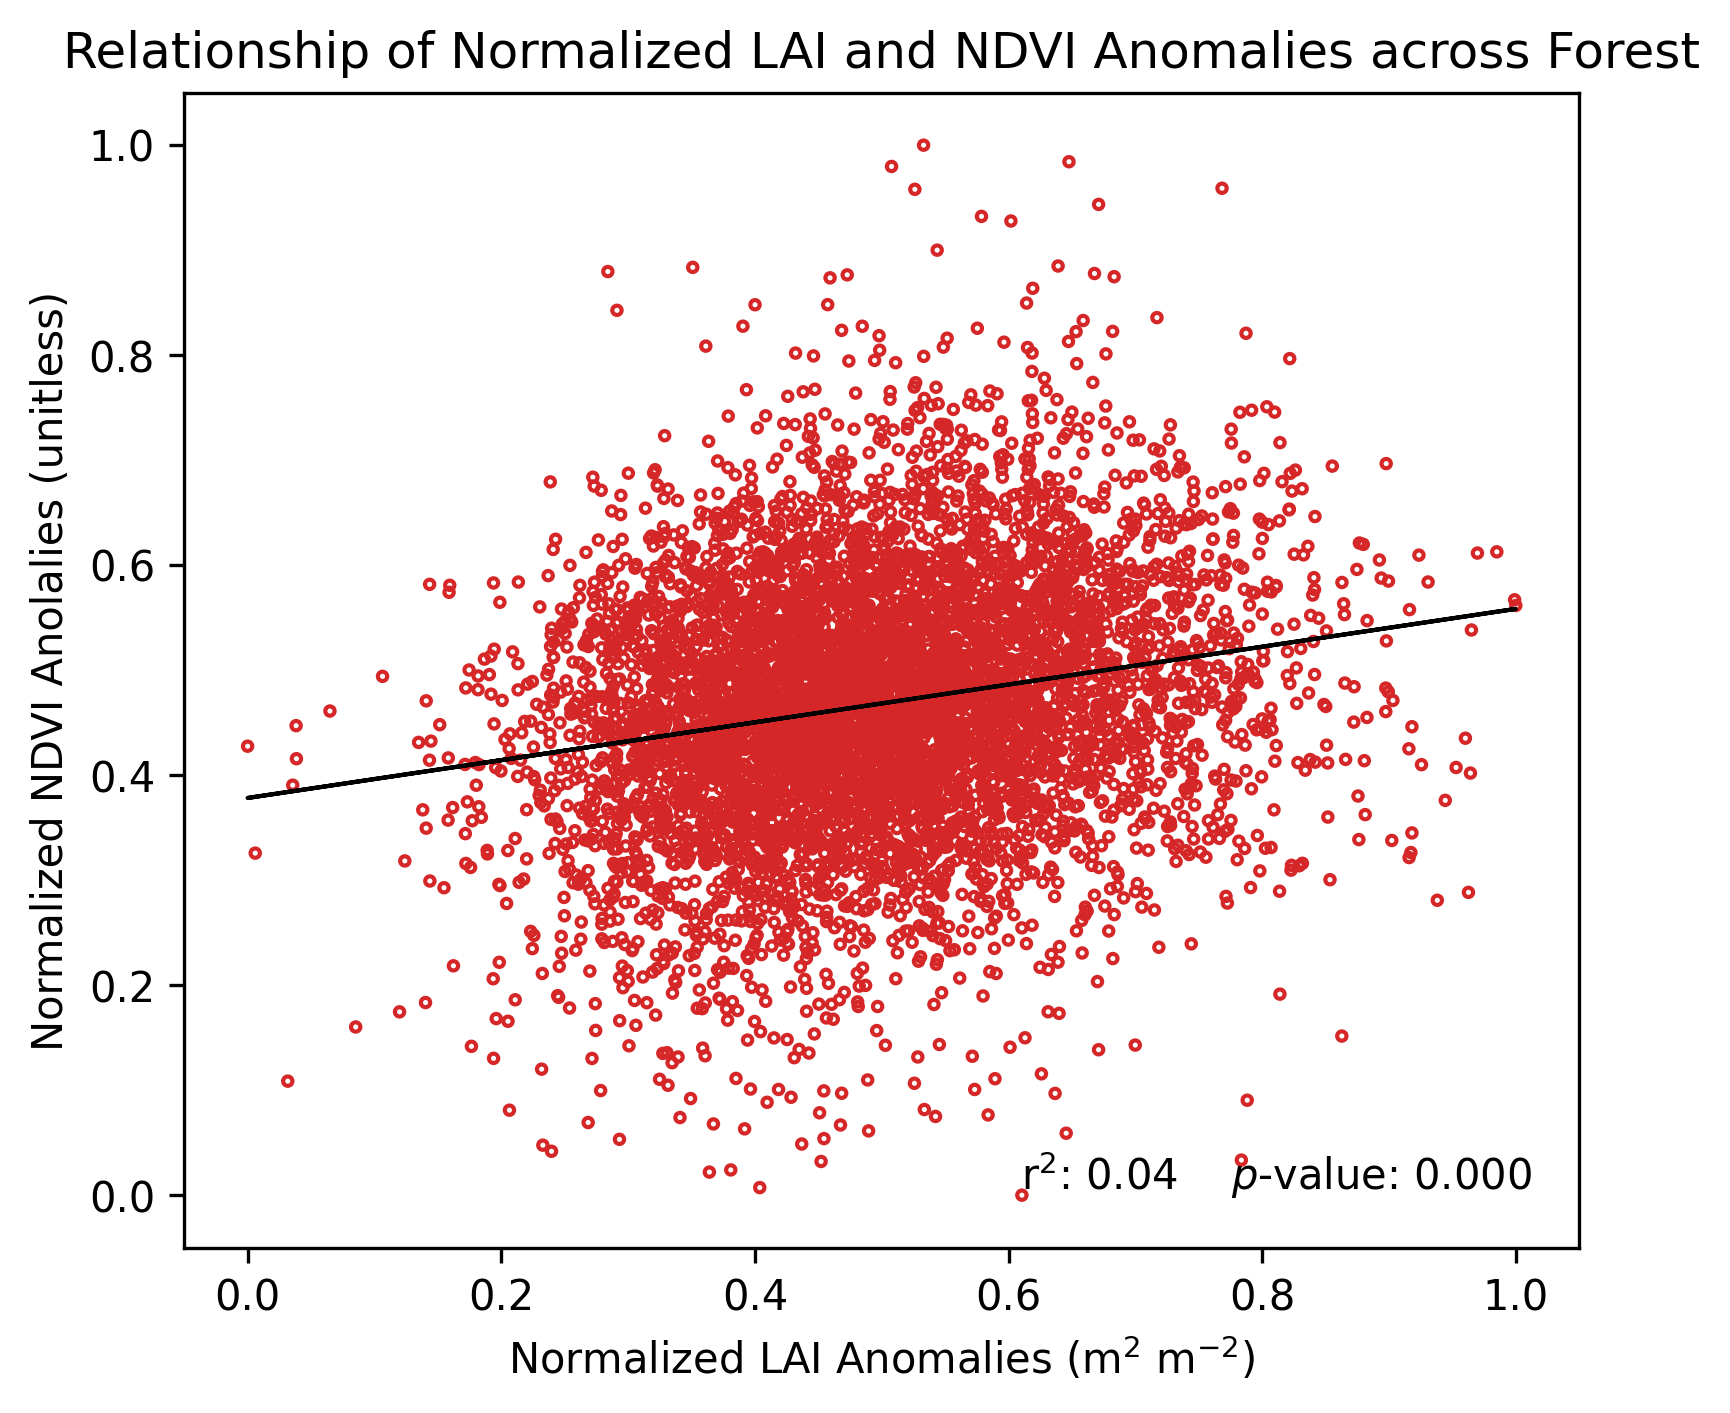

In [15]:
z0[z0>1.5] = np.nan
z1[z1<-0.1] = np.nan
z1[z1>0.09] = np.nan
from sklearn.preprocessing import MinMaxScaler
fig, ax = plt.subplots(1,1,dpi=300,figsize=(6,5))
z0_clean = z0[~np.isnan(z1)]
z0_clean1 = z0_clean[~np.isnan(z0_clean)]
z1_clean = z1[~np.isnan(z0)]
z1_clean1 = z1_clean[~np.isnan(z1_clean)]
scaler = MinMaxScaler()
z0_sta = scaler.fit_transform(z0_clean1.reshape(-1, 1)).flatten()
z1_sta = scaler.fit_transform(z1_clean1.reshape(-1, 1)).flatten()
res = stats.linregress(z0_sta, z1_sta)
plt.plot(z0_sta, res.intercept+res.slope*z0_sta, color='black', linestyle='-', lw=1)
plt.text(0.6, 0.05, f"r$^2$: {res.rvalue**2:.2f}    $p$-value: {res.pvalue:.3f}", transform=ax.transAxes)
plt.scatter(z0_sta, z1_sta, s=5, facecolors='none', edgecolors='tab:red')
plt.xlabel('Normalized LAI Anomalies (m$^2$ m$^{-2}$)')
plt.ylabel('Normalized NDVI Anolalies (unitless)')
plt.title('Relationship of Normalized LAI and NDVI Anomalies across Forest')

Text(0.5, 1.0, 'Relationship of Normalized LAI and NDVI Anomalies across Cropland')

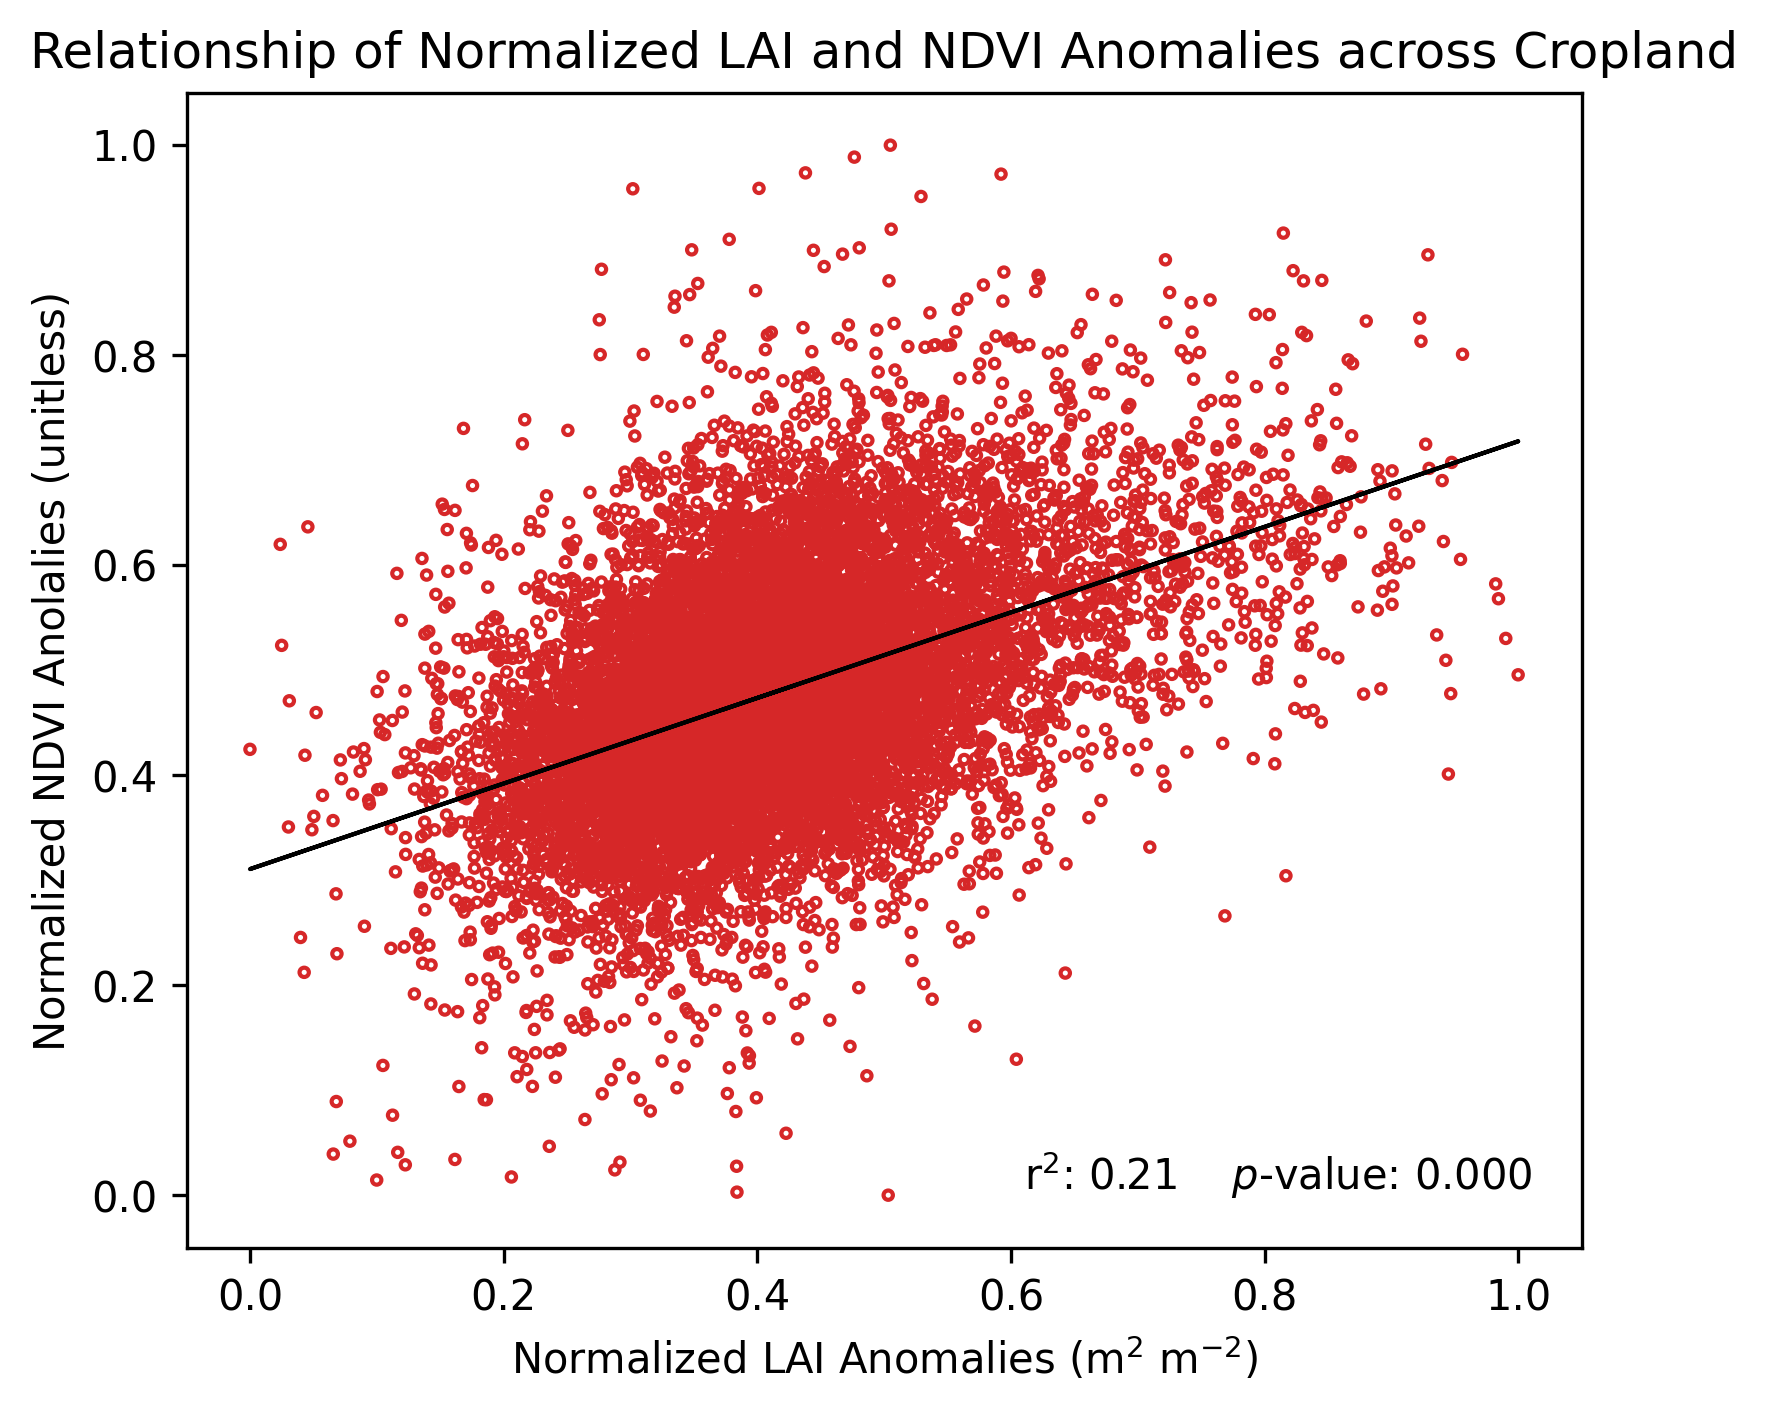

In [16]:
z2[z2>1] = np.nan
z2[z2<-0.65] = np.nan
z3[z3<-0.2] = np.nan
z3[z3>0.2] = np.nan
from sklearn.preprocessing import MinMaxScaler
fig, ax = plt.subplots(1,1,dpi=300,figsize=(6,5))
z2_clean = z2[~np.isnan(z3)]
z2_clean1 = z2_clean[~np.isnan(z2_clean)]
z3_clean = z3[~np.isnan(z2)]
z3_clean1 = z3_clean[~np.isnan(z3_clean)]
scaler = MinMaxScaler()
z2_sta = scaler.fit_transform(z2_clean1.reshape(-1, 1)).flatten()
z3_sta = scaler.fit_transform(z3_clean1.reshape(-1, 1)).flatten()
res = stats.linregress(z2_sta, z3_sta)
plt.plot(z2_sta, res.intercept+res.slope*z2_sta, color='black', linestyle='-', lw=1)
plt.text(0.6, 0.05, f"r$^2$: {res.rvalue**2:.2f}    $p$-value: {res.pvalue:.3f}", transform=ax.transAxes)
plt.scatter(z2_sta, z3_sta, s=5, facecolors='none', edgecolors='tab:red')
plt.xlabel('Normalized LAI Anomalies (m$^2$ m$^{-2}$)')
plt.ylabel('Normalized NDVI Anolalies (unitless)')
plt.title('Relationship of Normalized LAI and NDVI Anomalies across Cropland')